# sivtempfit tutorial 

## Getting started
First, import the package. This assumes that the package is already downloaded and installed.

If you need to download and install the package, please see the readme on the [github page](https://github.com/p201-sp2016/sivtempfit).

In [2]:
import sivtempfit as stf
import sivtempfit.io as io
import sivtempfit.inferMC as mc
import sivtempfit.model as model

We will also import a few other fairly standard packages to assist us. All of these packages are requirements for `sivtempfit`, so you should have them installed.

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import emcee
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("white")

## Import some data

In general, you will have some experimental data that consists of one-dimensional fluorescence spectra, i.e. fluorescence intensity or counts as a function of wavelength.

The package includes support for data in a simple `[x, y]` format where `x` is a numpy array of the x values and `y` is a numpy array of the y values.

The package also includes support for a `Spectrum` object, which is basically just a pandas dataframe with a `metadata` variable bolted onto it. The `sivtempfit.io` module includes some utilities to import these `Spectrum` objects, and the `Spectrum` object itself supports json output through the `write_json` method.

We'll use such a `Spectrum` object in this tutorial. For the purposes of this tutorial, let's import some example data (included with the package.) Let's import it using the `io` module.

In [10]:
path_to_json = io.get_example_data_file_path("test_experimental_spectrum.json")
test_spectrum = io.load_Spectrum(path_to_json)

Now, `simulated_spectrum` is a `Spectrum` object that has both data and metadata. We can examine both:

In [11]:
test_spectrum.metadata

{'Laser Frequency': '401.496 THz',
 'Name': 'Example spectrum of an SiV plus a laser calibration line taken at 300K.'}

In [12]:
test_spectrum.data[:10]

,counts,wavelength
0,1157,730.7841
1,1161,730.7931
10,1170,730.8741
100,1168,731.6841
1000,1543,739.7841
1001,1540,739.7931
1002,1562,739.8021
1003,1550,739.8111
1004,1539,739.8201
1005,1589,739.8291


## Visualize the example data

Let's visualize the example data:

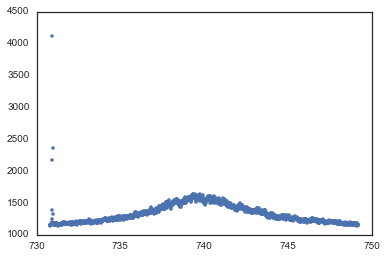

In [13]:
plt.plot(test_spectrum.data['wavelength'], test_spectrum.data['counts'], ".")

## Set up the model and MC sampling to perform inference

We have a model for this function that includes two lorentzian peaks plus gaussian background noise. The model is described in the likelihood function: 

In [14]:
print(model.two_peak_log_likelihood.__doc__)


    Returns the log-likelihood calculated for the two-peak + CCD noise model.
    See also: two_peak_model

    Parameters:
    -----------
    x : wavelength or x-axis value
    y : corresponding observed data value
    amp1 : amplitude of the broad SiV peak in the spectrum
    amp2 : amplitude of the narrow calibration peak in the spectrum
    T : The temperature of the sample
    m : The linear scaling of the SiV peak position with temperature
    C0 : The offset in the above linear scaling
    center2 : The position of the calibration line
    width1 : The width (FWHM) of the SiV line
    width2 : The width (FWHM) of the calibration line
    light_background : The contribution to the background from stray light,
                       contributing shot noise
    ccd_backgrond : The contribution to the background from CCD readout,
                    contributing gaussian noise
    ccd_stdev : The standard deviation on the gaussian CCD noise

    Optional Arguments:
    -----------

We would like to determine the parameters of the model that fit the data. To do this, we will do Bayesian parameter estimation by sampling the likelihood function using the [`emcee` Monte-Carlo sampler](http://dan.iel.fm/emcee/current/).

This likelihood function is the one used by the `emcee` sampler. The first step is to generate a set of starting points for the sampling; here, we will use an `emcee` `sample_ball` object. This is normally done automatically in the course of evaluating `mc_likelihood_sampler` but can also be done manually (and then passed to the `mc_likelihood_sampler`) for more fine-grained control.

Here is an example of the guesses. (Normally, `debug` should be set to `False` to generate the object; when it is `True`, it outputs the values instead.)

For more information, see the `generate_sample_ball` documentation.

In [21]:
mc.generate_sample_ball(test_spectrum, 731, debug = True)

((2056.5, 2056.5, 8, 731, 2, 0.02, 64.025000000000006, 1024.4000000000001, 10),
 (1645.2, 1645.2, 3, 0.5, 2, 0.05, 64.025000000000006, 512.20000000000005, 10))

In order to run the `emcee` sampler, simply run the `mc_likelihood_sampler` function which takes as mandatory arguments the data (in either `[x_array, y_array` form or in the form of a `Spectrum` object) and the expected position of the calibration peak.

For the example data, we can calculate this simply:

In [22]:
calib_pos_guess = test_spectrum.data['wavelength'][np.argmax(test_spectrum.data['counts'])]
calib_pos_guess

730.93709999999999

## Run the `emcee` sampler

Now, we can run the emcee sampler by calling the `mc_likelihood_sampler` function. By default, it runs the sampler right away. This can be disabled with the `run = False` kwarg. 

Let's run the sampler. For the sake of time, I will run only 20 steps, which is not very useful for inference but should only take a few minutes. The sampler also supports multithreaded sampling, although this feature has not been extensively tested.

In [23]:
%time test_sampler = mc.mc_likelihood_sampler(test_spectrum, 730.9, nwalkers = 18, nsteps = 20, threads = 8)

Wall time: 1min 18s


C:\Users\Ruffin\Dropbox\Harvard Physics\Classes\PHYS 201\Project\project code\sivtempfit\inferMC.py:248: RuntimeWarning: Multithreaded emcee is the context of the sivtempfit package is not thoroughly tested. Use at your own risk!
  RuntimeWarning)


## Extract results from the `emcee` sampler

To illustrate what is possible, and the typical results and type of analysis that can be expected, let's look at the samples from a much longer sampling run, about two hours (3000 steps with 36 walkers). This is also included in the example data.

In [27]:
samples_3k = np.load(io.get_example_data_file_path("samples_test_3000.npy"))

Let's look at the traces to estimate the burn-in time. This plotting command actually takes quite a bit of time, so please be patient.

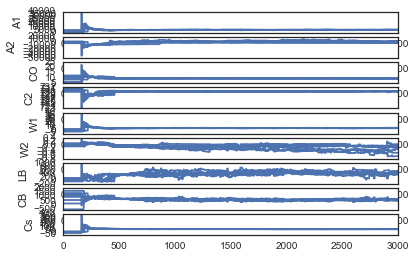

In [26]:
fig, (ax_amp1, ax_amp2, ax_c0, ax_center2, ax_width1, ax_width2, ax_lb, ax_ccdb, ax_ccds) = plt.subplots(9)
ax_amp1.set(ylabel='A1')
ax_amp2.set(ylabel='A2')
ax_c0.set(ylabel='CO')
ax_center2.set(ylabel='C2')
ax_width1.set(ylabel='W1')
ax_width2.set(ylabel='W2')
ax_lb.set(ylabel='LB')
ax_ccdb.set(ylabel='CB')
ax_ccds.set(ylabel='Cs')
for i in range(9):
    sns.tsplot(samples_3k[i,:,0], ax=ax_amp1)
    sns.tsplot(samples_3k[i,:,1], ax=ax_amp2)
    sns.tsplot(samples_3k[i,:,2], ax=ax_c0)
    sns.tsplot(samples_3k[i,:,3], ax=ax_center2)
    sns.tsplot(samples_3k[i,:,4], ax=ax_width1)
    sns.tsplot(samples_3k[i,:,5], ax=ax_width2)
    sns.tsplot(samples_3k[i,:,6], ax=ax_lb)
    sns.tsplot(samples_3k[i,:,7], ax=ax_ccdb)
    sns.tsplot(samples_3k[i,:,8], ax=ax_ccds)

Burn-in occurs around 800 samples, so let's drop the first 1000 samples and then look at the distribution of the parameters that we care about: `C0`, the offset between the two peaks; `C2`, the position of the second (calibration) peak; and `w1`, the width of the first peak.

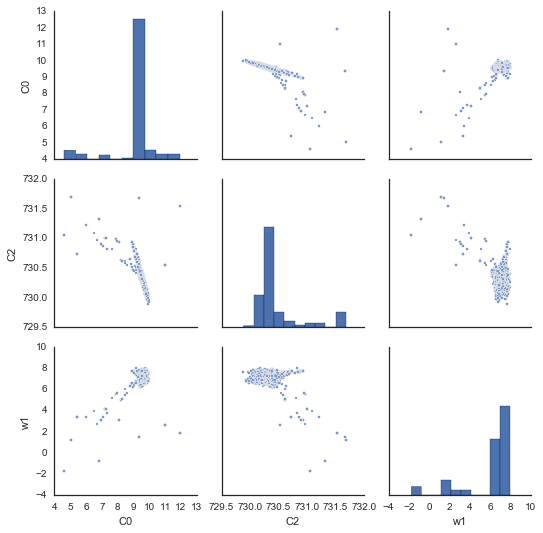

In [29]:
samples = samples_3k[:,1000:,:]
traces = samples.reshape(-1, 9).T
parameter_samples = pd.DataFrame({'C0': traces[2], 'C2': traces[3], 'w1': traces[4]})
sns.pairplot(parameter_samples, markers='.')

The result that we care about the most is the predicted offset in the center position. This corresponds to the physical wavelength of the SiV center after accounting for the calibration laser position. So, let's plot the marginalized distribution for this parameter:

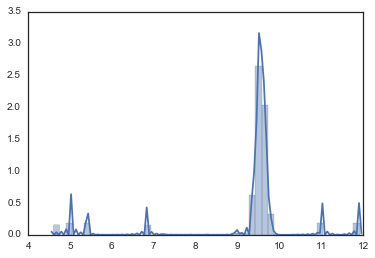

In [37]:
sns.distplot(traces[2,:])

Although there are some small peaks at unreasonable offsets, most of the density is concentrated between 9 and 10. The width in that region is an estimate of our uncertainty in this parameter:

[9, 10, 0, 3.5]

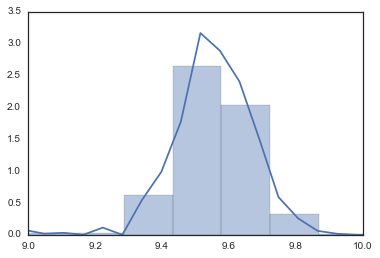

In [38]:
sns.distplot(traces[2,:])
plt.axis([9, 10, 0, 3.5])

The width is about 0.4, which is about what we expect from naive curve fitting under a gaussian error framework.

We can also look at the uncertainty in the laser line, which should be much less. Again, zooming into the main peak of the likelihood:

[729.75, 730.75, 0, 3.5]

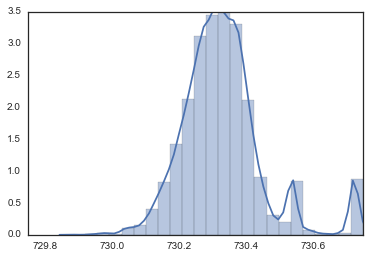

In [40]:
sns.distplot(traces[3,:])
plt.axis([729.75, 730.75, 0, 3.5])

The uncertainty in the position of this line is around 0.2, which is about two pixels on the CCD and is a bit less than the width of the line on the CCD.